![R](https://img.shields.io/badge/r-%23276DC3.svg?style=logo&logo=r&logoColor=white)
<a href="https://colab.research.google.com/github/maciejskorski/enhanced-pll-trng/blob/main/src/PLL_TRNG_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange.svg)](https://nbviewer.org/github/maciejskorski/enhanced-pll-trng/blob/main/src/PLL_TRNG_Model.ipynb)



# Global Parameters

In [1]:
#Self consistent file (repo)

#Global parameters
#Frequency of the sampling clock (in Hz)
f0<-129.46e6 #Hz
#KM and KD such that KDxf0=KMxf1
KM<-728 #KM1*KD0
KD<-435 #KM0*KD1
#Equivalent Period Jitter (in s) in f1
sigma<-10e-12 #s

#Thresholds to consider samples as contributors (thresholds) (if prmin=0 and prmax=1, all samples are considered as contributors. In the article prmin=0.02275 and prmax=0.97725
prmin<- 0.02275 #0
prmax<- 0.97725 #1

#Computations from global parameters
Tclk<-1/f0
Tclj<-KD*Tclk/KM
delta<-Tclj/KD

# Auxiliary Functions

In [2]:
######################################################################################## Function definitions ####################################################################################
#Functions used in the model
#Probability to have a '1' for sample i(j) (samples are obtained for i from 0 to KD-1) and rearranged such that they are sorted in increasing order (j) along the period Tclj.
#j: the index in the reconstructed period j is in [|0;KD-1|]
#phi0: initial phase shift between the first sampled clock and the sampling one (in sec)
#dc: duty cycle in ]0;1[, usually dc=.5
#sig: jitter (in ps) accumulated inside the PLL
PX_i_jeq1_ph_dc<-function(j,sig,phi0,dc)
{
	muj<-((phi0+j*delta) %% Tclj)
	#Formula according to Prop. 2 in the article
	return(1-pnorm(Tclj,muj,sig)+pnorm(dc*Tclj,muj,sig)-pnorm(0,muj,sig))
}

#Compute the mean value of the Poisson binomial distribution of (Xj)_j in 0 Kd-1
Np_mean<-function(sig,phi0,dc){
	return(
		sum(PX_i_jeq1_ph_dc((1:KD)-1,sig,phi0,dc))
	)
}

#Compute the variance value of the Poisson binomial distribution of (Xj)_j in 0 Kd-1
Np_var<-function(sig,phi0,dc){
	probXj<-PX_i_jeq1_ph_dc((1:KD)-1,sig,phi0,dc)
	#Keep only Contributors or all samples leads to reduce the threshold in the worst case.
	#
	smin<-prmin
	smax<-prmax
	probXj<-probXj[probXj>=smin & probXj<=smax]
	return(
		sum(probXj*(1-probXj))
	)
}

#Obtain sigma for a given N_var, in order to compute the entropy (Shannon or min), always assuming independence
#v: Experimental computation of the variance
#phi0: initial phase shift between the first sampled clock and the sampling one (in sec)
#dc: duty cycle in ]0;1[, usually dc=.5
Var2sig<-function(v,sigmin,sigmax,phi0,dc){
	l<-ceiling(log(1e14*(sigmax-sigmin))/log(2))
	a<-sigmin
	b<-sigmax
	while((Np_var(a,phi0,dc)-v)*(Np_var(b,phi0,dc)-v)>=0)
	{
		a<-a/2
		b<-b*2
	}
	i<-1
	while(i<=l)
	{
		m<-(a+b)/2
		if((Np_var(m,phi0,dc)-v)*(Np_var(b,phi0,dc)-v)<0)
		{
			a<-m
		} else {
		       b<-m
		}
		i<-i+1
	}
	return(m)
}


#Take a vector of probabilities p_j as input and compute the probability that the xor is equal to one (assuming independence).
#Davies formula for a little bit length vector
proba_xor<-function(vec_prob){
	l<-length(vec_prob)
	return(.5+(-2)^(l-1)*prod((vec_prob)-1/2))
}

#Shannon entropy of a binary random variable (assuming independence)
Entropie_2<-function(p0){
	if((p0==0) | (p0==1)) ent<-0
	else ent<--log(p0)/log(2)*p0 -log(1-p0)/log(2)*(1-p0)
	return(ent)
}

#Min entropy of a binary random variable (assuming independence)
Entropie_min<-function(p0){
	if((p0==0) | (p0==1)) ent<-0
	else{
		p<-max(p0,1-p0)
		ent<--log(p)/log(2)
 	}
	return(ent)
}


#Entropy_rate (assuming independence and comuted from sufficiently distant contributors)
#Shannon_min: 0 -> Shannon | 1->min
H_rate<-function(sig,phi0,dc,Shannon_min)
{
	pp<-PX_i_jeq1_ph_dc(1:KD-1,sig,phi0,dc)
	#Keep only Contributors or all samples
	smin<-prmin
	smax<-prmax
	pp<-pp[pp>=smin & pp<=smax]
	pN0<-proba_xor(pp)
	if(Shannon_min){
		ent<-Entropie_min(pN0)
	}
	else{
		ent<-Entropie_2(pN0)
	}
	return(ent)
}


#Search a minimum jitter satisfying a given level of entropy (thre), thre=0.98 for min entropy
#Shannon_min: 0 -> Shannon | 1->min
Search_threshold<-function(sigmin,sigmax,phi0,dc,thre,Shannon_min)
{
	#18=6+12 (precision: 1e-6)
	l<-ceiling(log(1e18*(sigmax-sigmin))/log(2))
	a<-sigmin
	b<-sigmax

	while((H_rate(a,phi0,dc,Shannon_min)-thre)*(H_rate(b,phi0,dc,Shannon_min)-thre)>=0)
	{
		a<-a/2
		b<-b*2
	}
	i<-1
	while(i<=l)
	{
		m<-(a+b)/2
		if((H_rate(m,phi0,dc,Shannon_min)-thre)*(H_rate(b,phi0,dc,Shannon_min)-thre)<0)
		{
			a<-m
		} else {
		       b<-m
		}
		i<-i+1
	}
	return(m)
}

######################################################################################## End of function definitions ####################################################################################

# Plots

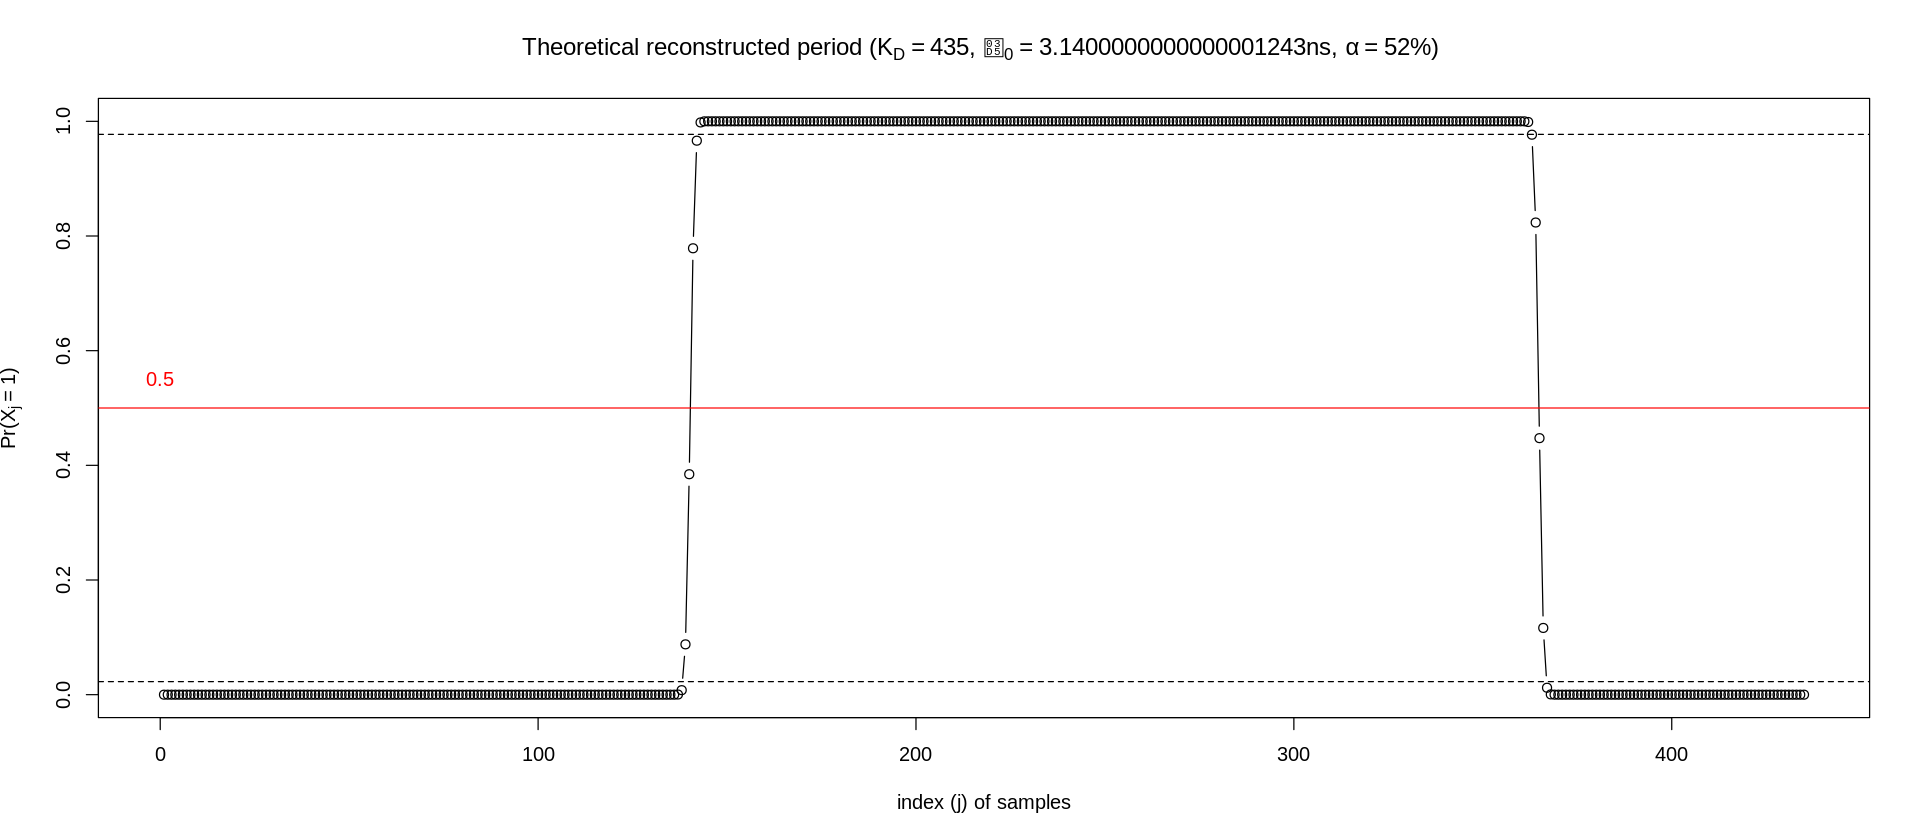

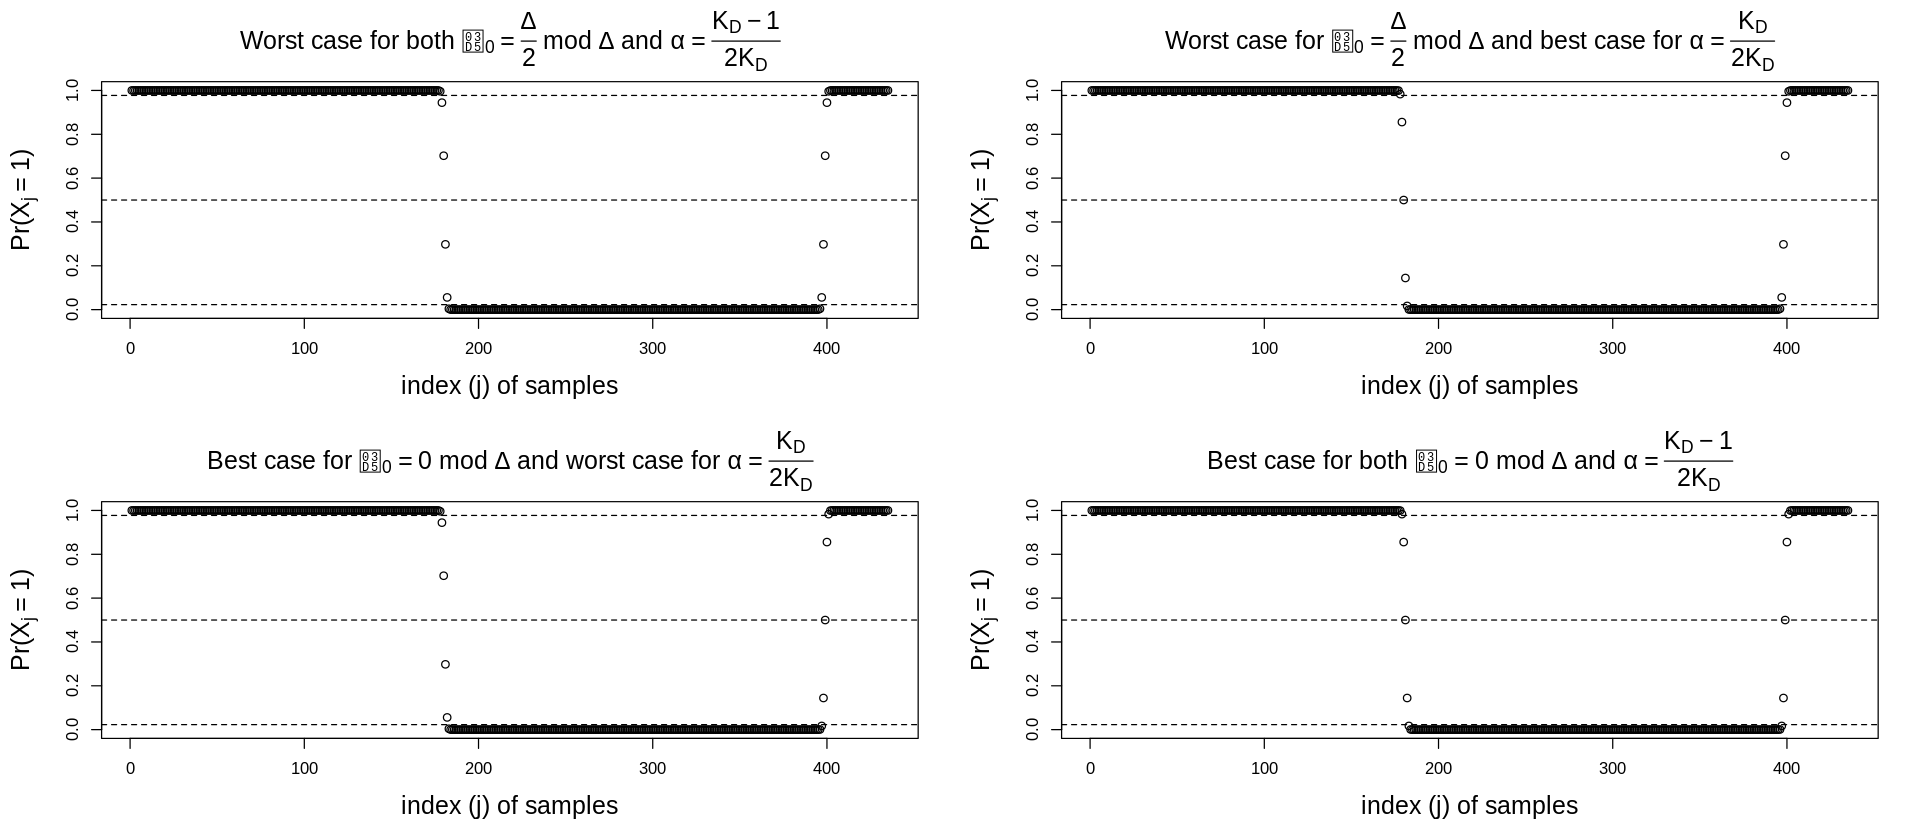

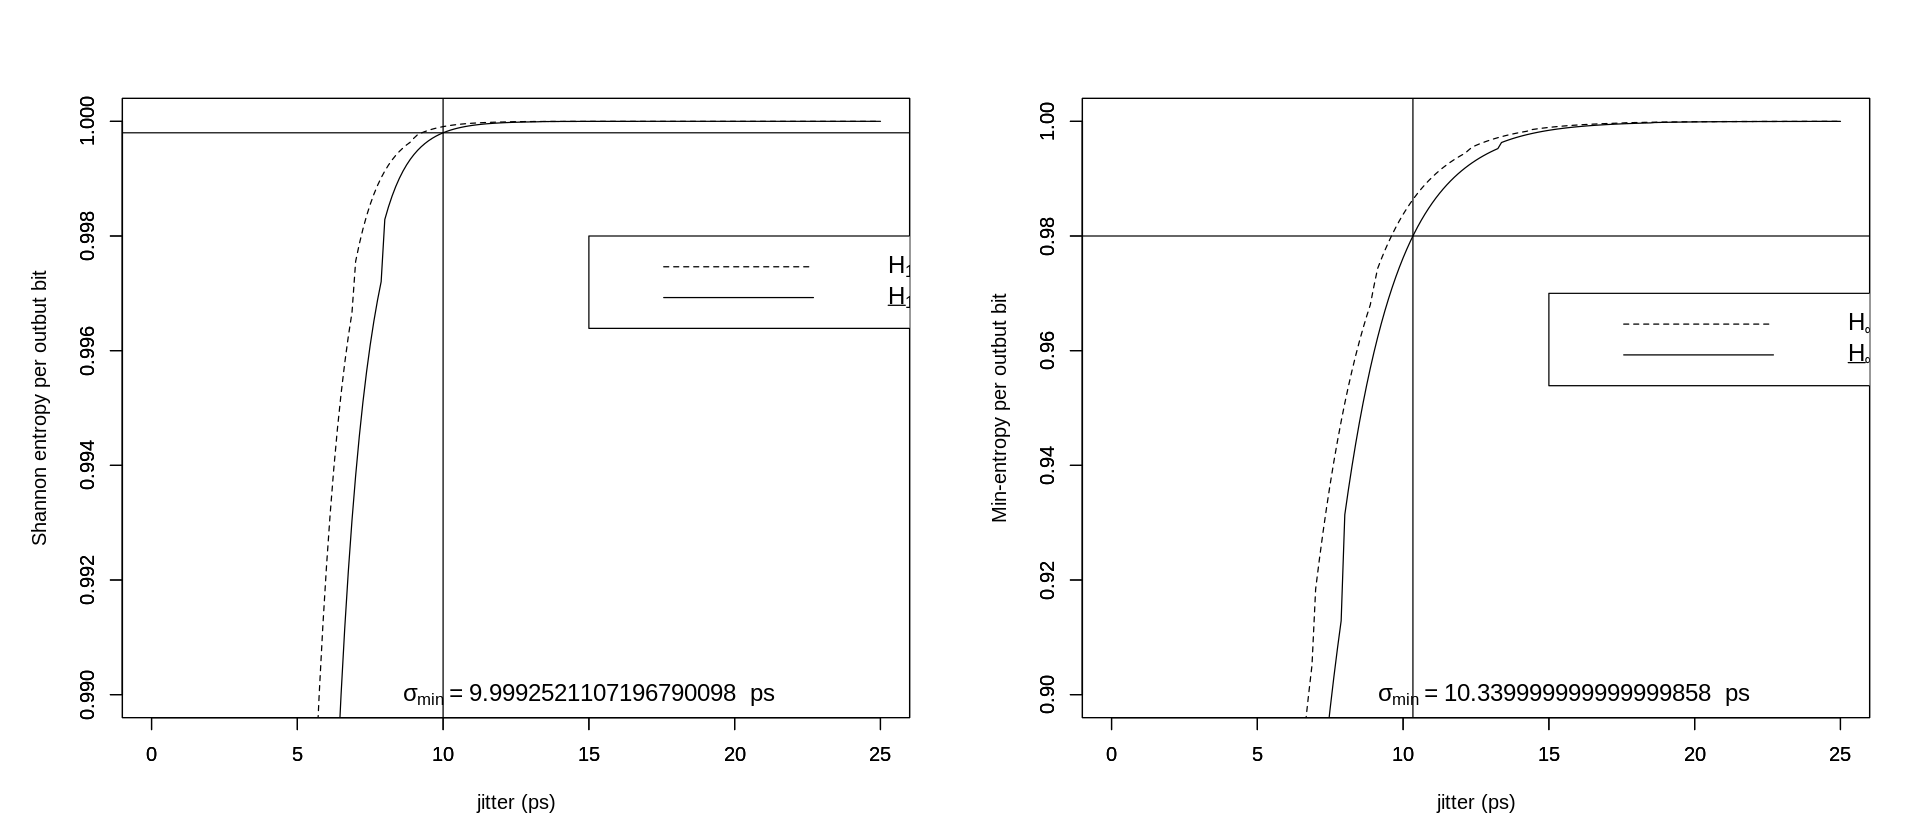

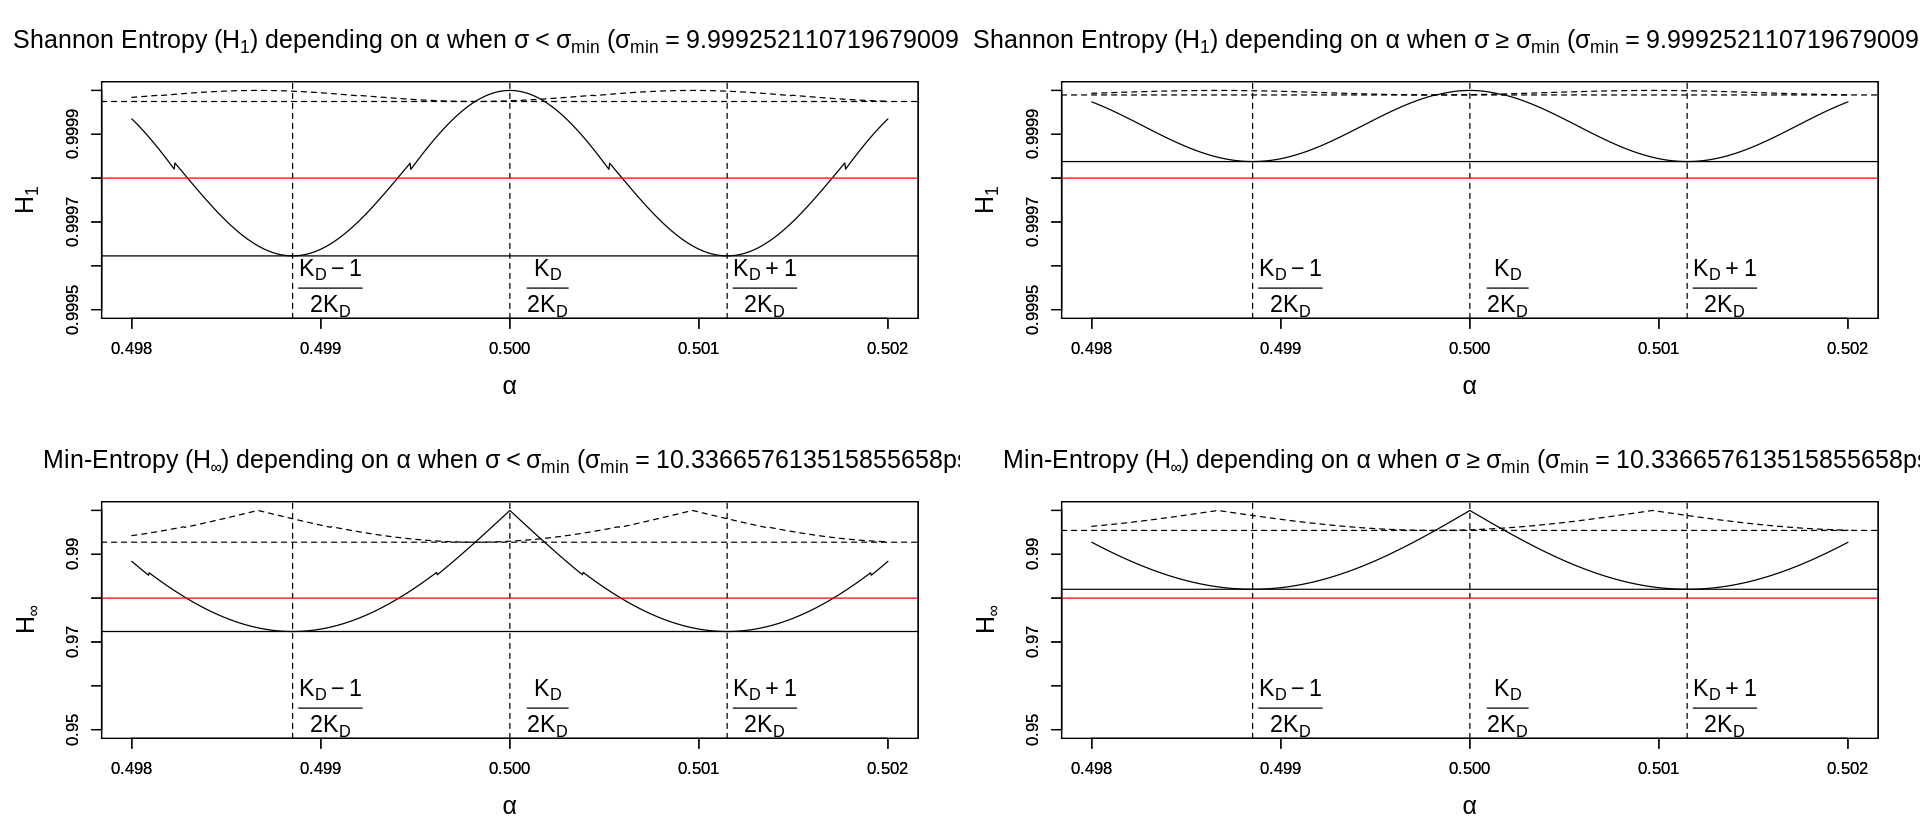

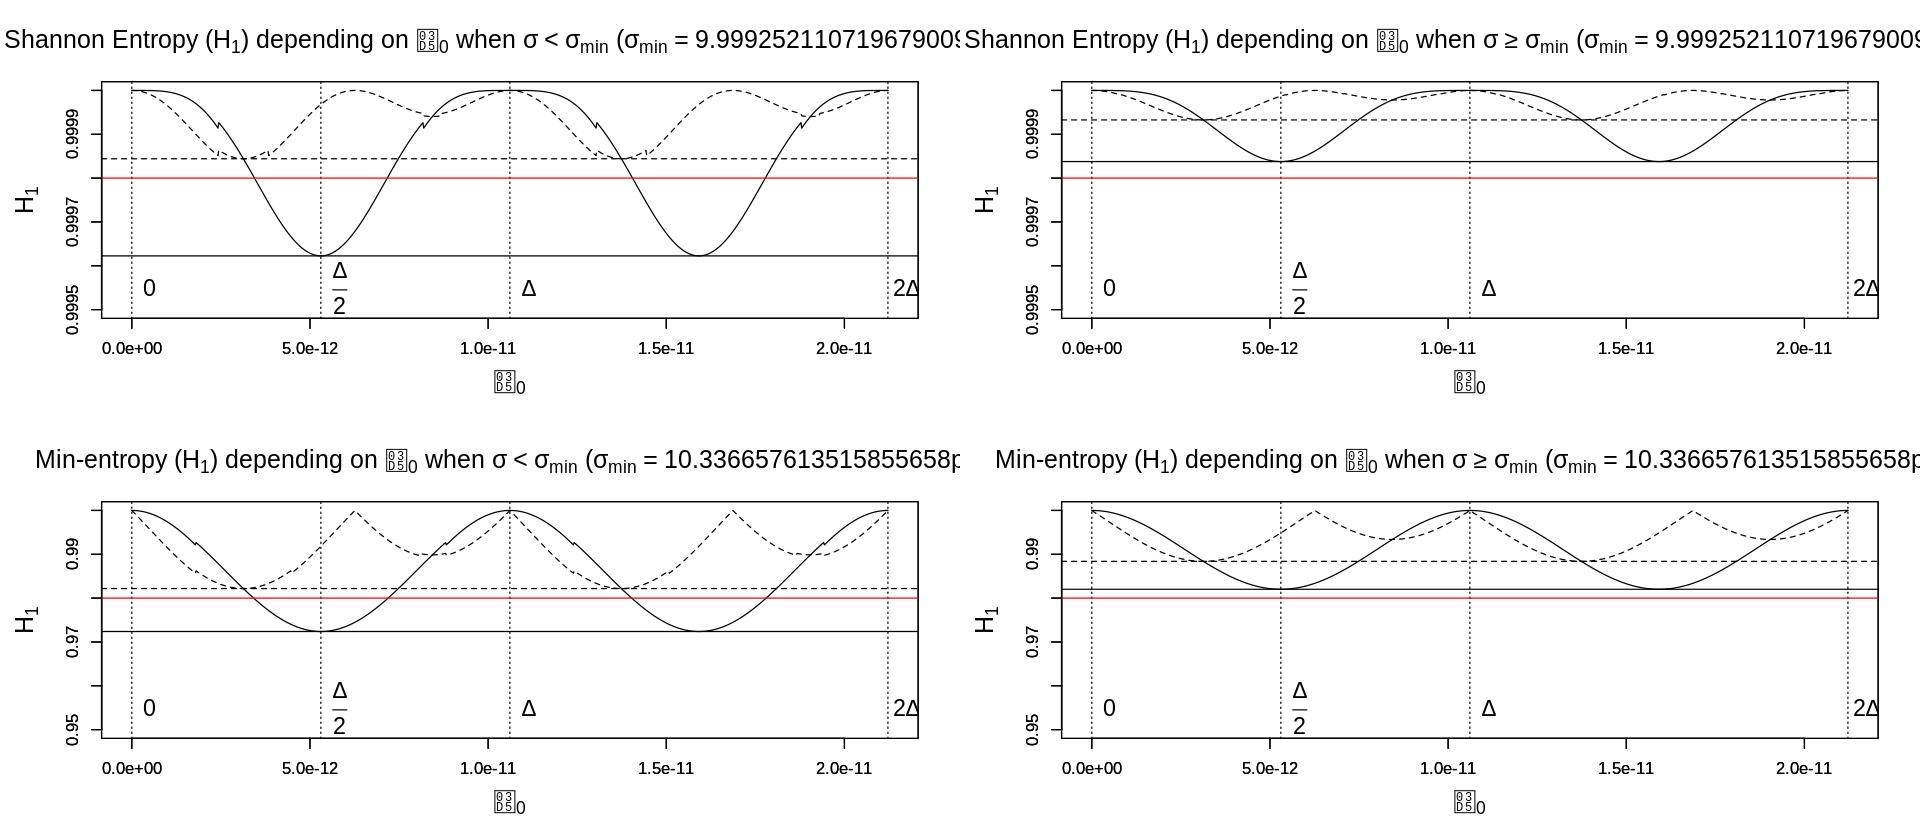

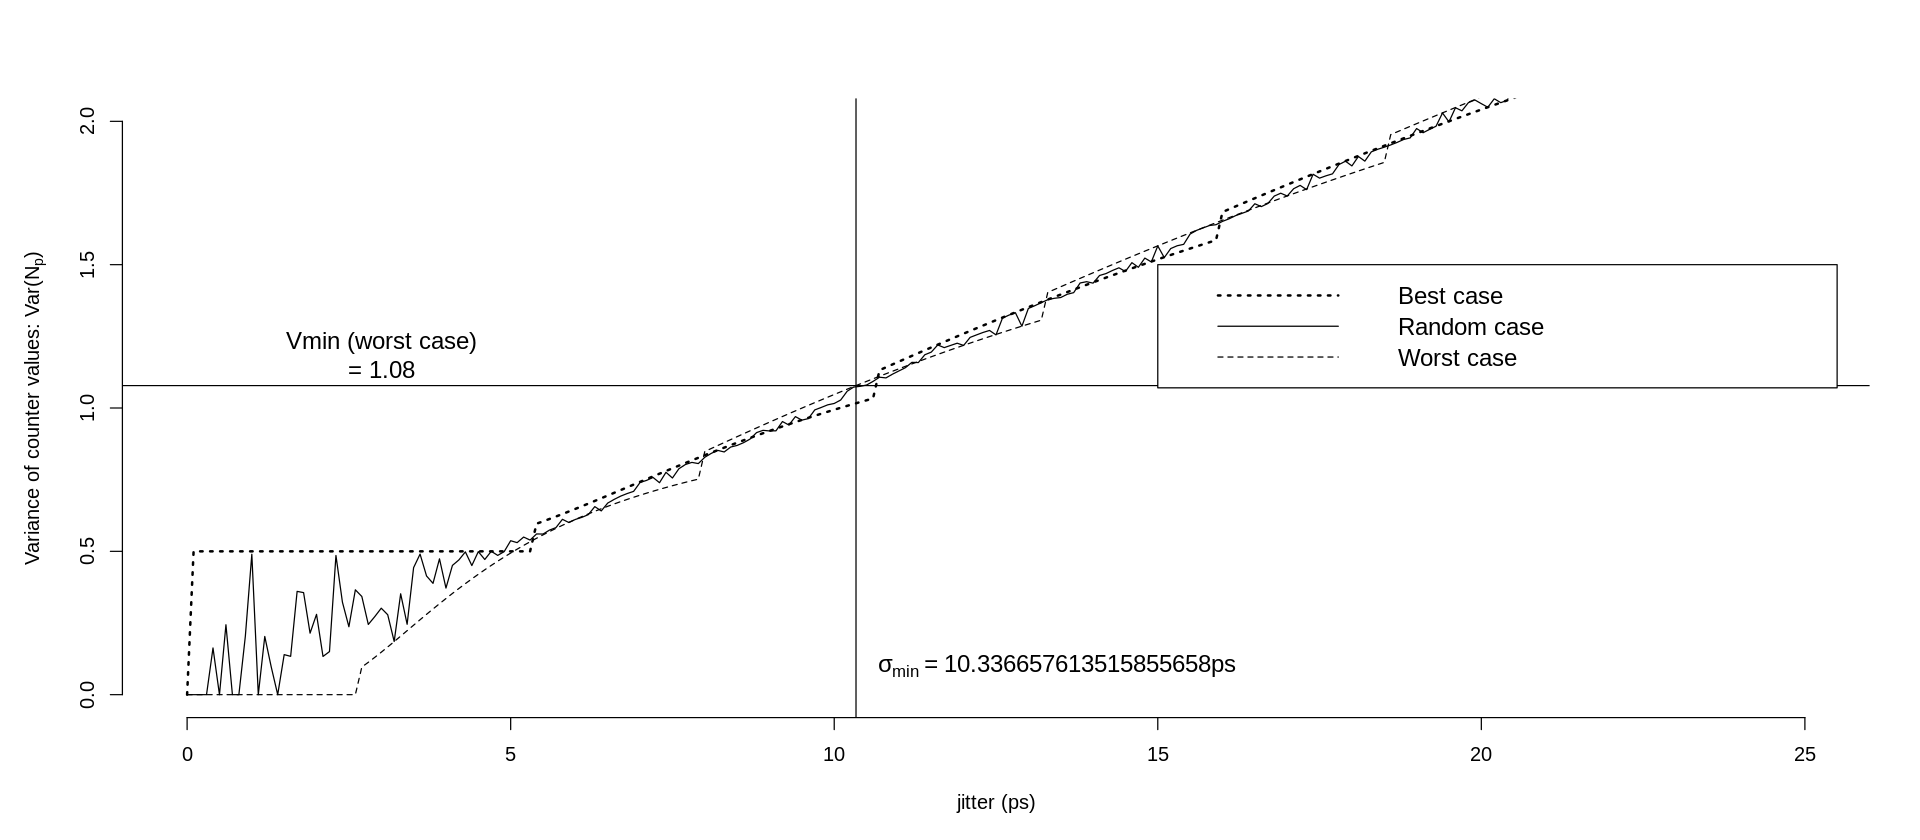

In [3]:
################################################################################################## Plots ################################################################################################

options(repr.plot.width = 16)

#Reconstructed period: random initial phase, random duty cycle
phi0<-runif(1,0,Tclj)
dc<-runif(1,0.47,0.53)
pp_r<-PX_i_jeq1_ph_dc(1:KD-1,sigma,phi0,dc)
options(digits=2)
par(mfrow=c(1,1))
plot(pp_r,type='b',xlab="index (j) of samples",ylab=bquote(paste("Pr(",X[j]==1,")")),main=bquote(paste("Theoretical reconstructed period (", K[D]==.(KD),", ", varphi[0]==.(round(phi0*1e9,2)),"ns, ", alpha==.(round(dc*100,0)),"%)",sep=" ")))
abline(h=0.5,col="red")
#Contributors betwwe prmin and prmax
abline(h=c(prmin,prmax),lty=2)
text(0,0.55,"0.5",col="red")
options(digits=20)
######################

par(ask=T)

#Reconstructed period for 4 special cases: Worst case for both phi0, alpha, worst case for phi0 and best case for alpha, worst case for alpha and best case for phi0, best case for both phi0, alpha.
couleur<-"black" #worst case
dc_id<-(KD-1)/(2*KD)
par(mfrow=c(2,2))
pp_worst<-PX_i_jeq1_ph_dc(1:KD-1,sigma,delta/2+37*delta,dc_id)
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(pp_worst,xlab="index (j) of samples",ylab=bquote(paste("Pr(",X[j]==1,")")),main=bquote(paste("Worst case for both ",varphi[0]==frac(Delta,2)," mod ",Delta, " and ",alpha==frac(K[D]-1,2*K[D]))),cex.lab=1.5,cex.main=1.5)
abline(h=0.5,lty=2)
#Contributors betwwe prmin and prmax
abline(h=c(prmin,prmax),lty=2)

pp_inter1<-PX_i_jeq1_ph_dc(1:KD-1,sigma,delta/2+37*delta,dc_id-1/(2*KD))
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(pp_inter1,xlab="index (j) of samples",ylab=bquote(paste("Pr(",X[j]==1,")")),main=bquote(paste("Worst case for ",varphi[0]==frac(Delta,2)," mod ",Delta, " and best case for ",alpha==frac(K[D],2*K[D]))),cex.lab=1.5,cex.main=1.5)
abline(h=0.5,lty=2)
#Contributors betwwe prmin and prmax
abline(h=c(prmin,prmax),lty=2)

pp_inter2<-PX_i_jeq1_ph_dc(1:KD-1,sigma,0+37*delta,dc_id-1/(2*KD))
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(pp_inter2,xlab="index (j) of samples",ylab=bquote(paste("Pr(",X[j]==1,")")),main=bquote(paste("Best case for ",varphi[0]==0," mod ",Delta, " and worst case for ",alpha==frac(K[D],2*K[D]))),cex.lab=1.5,cex.main=1.5)
abline(h=0.5,lty=2)
#Contributors betwwe prmin and prmax
abline(h=c(prmin,prmax),lty=2)

pp_id<-PX_i_jeq1_ph_dc(1:KD-1,sigma,0+37*delta,dc_id)
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(pp_id,xlab="index (j) of samples",ylab=bquote(paste("Pr(",X[j]==1,")")),main=bquote(paste("Best case for both ",varphi[0]==0," mod ",Delta, " and ",alpha==frac(K[D]-1,2*K[D]))),cex.lab=1.5,cex.main=1.5)
abline(h=0.5,lty=2)
#Contributors betwwe prmin and prmax
abline(h=c(prmin,prmax),lty=2)

######################

par(ask=T)

######################
#Plot the entropy (Shannon (left), Min'Entropy (right)) in the worst case as a function of the jitter and five other entropy curves for random alpha and phi0
par(mfrow=c(1,2))
phi0_worst<-delta/2
dc_id<-(KD-1)/(2*KD)
#init with jitt=0
H1_vec_worst<-H_rate(0,phi0_worst,dc_id,0)
Hmin_vec_worst<-H_rate(0,phi0_worst,dc_id,1)

#random case:
phi<-runif(1,0,Tclj)
dc<-runif(1,0.48,0.52)
H1_vec_r<-H_rate(0,phi,dc,0)
Hmin_vec_r<-H_rate(0,phi,dc,1)

jitt_vec<-c(1:200)/200*25e-12
for(jitt in jitt_vec)
{
	#Worst case
	H1_vec_worst<-c(H1_vec_worst,H_rate(jitt,phi0_worst,dc_id,0))
	Hmin_vec_worst<-c(Hmin_vec_worst,H_rate(jitt,phi0_worst,dc_id,1))

	#Random
	H1_vec_r<-c(H1_vec_r,H_rate(jitt,phi,dc,0))
	Hmin_vec_r<-c(Hmin_vec_r,H_rate(jitt,phi,dc,1))
}
options(digits=4)
sig_min_sh<-Search_threshold(0e-12,25e-12,phi0_worst,dc_id,0.9998,0)
plot(c(0,jitt_vec)*1e12,H1_vec_r,ylim=c(0.99,1),type='l',xlab="",ylab="",lty=2)
par(new=T)
plot(c(0,jitt_vec)*1e12,H1_vec_worst,ylim=c(0.99,1),type='l',xlab="jitter (ps)",ylab="Shannon entropy per outbut bit")
abline(h=0.9998)
abline(v=sig_min_sh*1e12)
#text(1.5*sig_min_sh*1e12,0.99,paste("jitt_min =",round(sig_min_sh*1e12,2),"ps"))
#text(1.5*sig_min_sh*1e12,0.99,expression(sigma[min]) ~ paste("=",round(sig_min_sh*1e12,2),"ps")))#paste(expression(sigma[min]~'='),round(sig_min_sh*1e12,2),"ps"))
options(digits=4)
#x<-round(sig_min_sh*1e12,2)
#text(1.5*sig_min_sh*1e12,0.99,bquote(sigma[min]==.(round(x,2))~"ps"),cex=1.2)
text(1.5*sig_min_sh*1e12,0.99,bquote(sigma[min]==.(sig_min_sh*1e12)~"ps"),cex=1.2)
legend(15,0.998,legend=c(expression(H[1]~"(random)"),expression(underline(H)[1]~"(worst case)")),lty=c(2,1),cex=1.2)
sig_min_min<-Search_threshold(0e-12,25e-12,phi0_worst,dc_id,0.98,1)
plot(c(0,jitt_vec)*1e12,Hmin_vec_r,ylim=c(0.9,1),type='l',xlab="",ylab="",lty=2)
par(new=T)
plot(c(0,jitt_vec)*1e12,Hmin_vec_worst,ylim=c(0.9,1),type='l',xlab="jitter (ps)",ylab="Min-entropy per outbut bit")
abline(h=0.98)
abline(v=sig_min_min*1e12)
x<-round(sig_min_min*1e12,2)
text(1.5*sig_min_min*1e12,0.9,bquote(sigma[min]==.(round(x,2))~"ps"),cex=1.2)
legend(15,0.97,legend=c(expression(H[infinity]~"(random)"),expression(underline(H)[infinity]~"(worst case)")),lty=c(2,1),cex=1.2)
options(digits=20)
######################

par(ask=T)

######################
#Plot Entropy (min, Shannon) curves as a function of the duty cycle alpha for a random initial phase (dotted line) and the worst case for phi0 (solid line)

#Determining thresholds on sigma to get sufficient entropy (in the worst case for phi0 and alpha)
#sigmin for Shannon entropy>0.9998
sigmin1<-Search_threshold(0,50e-12,delta/2,dc_id,0.9998,0)
#sigmin for Min-entropy>0.98
sigminmin<-Search_threshold(0,50e-12,delta/2,dc_id,0.98,1)

#Set a jitter below the minimum jitter
jitt_b<-0.94*sigmin1
jitt_u<-1.02*sigmin1

#Set a jitter greater than the minimum jitter
jitt_b_min<-0.94*sigminmin
jitt_u_min<-1.02*sigminmin

#Random initial phase
phi0<-runif(1,0,delta)
#Ideal worst case:
phi0_worst<-delta/2
dc_min<-0.498
dc_max<-0.502

H1_vec_b<-H_rate(jitt_b,phi0,dc_min,0)
H1_vec_id_b<-H_rate(jitt_b,phi0_worst,dc_min,0)
Hmin_vec_b<-H_rate(jitt_b_min,phi0,dc_min,1)
Hmin_vec_id_b<-H_rate(jitt_b_min,phi0_worst,dc_min,1)
H1_vec_u<-H_rate(jitt_u,phi0,dc_min,0)
H1_vec_id_u<-H_rate(jitt_u,phi0_worst,dc_min,0)
Hmin_vec_u<-H_rate(jitt_u_min,phi0,dc_min,1)
Hmin_vec_id_u<-H_rate(jitt_u_min,phi0_worst,dc_min,1)


vec_dc<-dc_min+(1:1000)/1000*(dc_max-dc_min)
for(dc in vec_dc){
	H1_vec_b<-c(H1_vec_b,H_rate(jitt_b,phi0,dc,0))
	H1_vec_id_b<-c(H1_vec_id_b,H_rate(jitt_b,phi0_worst,dc,0))
	Hmin_vec_b<-c(Hmin_vec_b,H_rate(jitt_b_min,phi0,dc,1))
	Hmin_vec_id_b<-c(Hmin_vec_id_b,H_rate(jitt_b_min,phi0_worst,dc,1))
	H1_vec_u<-c(H1_vec_u,H_rate(jitt_u,phi0,dc,0))
	H1_vec_id_u<-c(H1_vec_id_u,H_rate(jitt_u,phi0_worst,dc,0))
	Hmin_vec_u<-c(Hmin_vec_u,H_rate(jitt_u_min,phi0,dc,1))
	Hmin_vec_id_u<-c(Hmin_vec_id_u,H_rate(jitt_u_min,phi0_worst,dc,1))
}
par(mfrow=c(2,2))
#Top left: Shannon entropy as a function of alpha for sigma<sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(dc_min,vec_dc),H1_vec_b,type='l',ylim=c(0.9995,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(dc_min,vec_dc),H1_vec_id_b,type='l',ylim=c(0.9995,1),col=couleur,main=bquote(paste("Shannon Entropy (",H[1],") depending on ",alpha, " when ",sigma<sigma[min]," (",sigma[min]==.(sigmin1*1e12),"ps)")),xlab=bquote(alpha),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(H1_vec_b),lty=2)
abline(h=min(H1_vec_id_b))
abline(v=c((KD-1)/(2*KD),KD/(2*KD),(KD-1)/(2*KD)+1/KD),lty=2)
text(0.5+0.0002,0.99955,bquote(frac(K[D],2*K[D])),cex=1.4)
text((KD-1)/(2*KD)+0.0002,0.99955,bquote(frac(K[D]-1,2*K[D])),cex=1.4)
text((KD+1)/(2*KD)+0.0002,0.99955,bquote(frac(K[D]+1,2*K[D])),cex=1.4)
abline(h=0.9998,col="red")

#Top right: Shannon entropy as a function of alpha for sigma>=sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(dc_min,vec_dc),H1_vec_u,type='l',ylim=c(0.9995,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(dc_min,vec_dc),H1_vec_id_u,type='l',ylim=c(0.9995,1),col=couleur,main=bquote(paste("Shannon Entropy (",H[1],") depending on ",alpha, " when ",sigma>=sigma[min]," (",sigma[min]==.(sigmin1*1e12),"ps)")),xlab=bquote(alpha),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(H1_vec_u),lty=2)
abline(h=min(H1_vec_id_u))
abline(v=c((KD-1)/(2*KD),KD/(2*KD),(KD-1)/(2*KD)+1/KD),lty=2)
text(0.5+0.0002,0.99955,bquote(frac(K[D],2*K[D])),cex=1.4)
text((KD-1)/(2*KD)+0.0002,0.99955,bquote(frac(K[D]-1,2*K[D])),cex=1.4)
text((KD+1)/(2*KD)+0.0002,0.99955,bquote(frac(K[D]+1,2*K[D])),cex=1.4)
abline(h=0.9998,col="red")

#Bottom left: Min-Entropy as a function of alpha for sigma<sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(dc_min,vec_dc),Hmin_vec_b,type='l',ylim=c(0.95,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(dc_min,vec_dc),Hmin_vec_id_b,type='l',ylim=c(0.95,1),col=couleur,main=bquote(paste("Min-Entropy (",H[infinity],") depending on ",alpha, " when ",sigma<sigma[min]," (",sigma[min]==.(sigminmin*1e12),"ps)")),xlab=bquote(alpha),ylab=bquote(H[infinity]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(Hmin_vec_b),lty=2)
abline(h=min(Hmin_vec_id_b))
abline(v=c((KD-1)/(2*KD),KD/(2*KD),(KD-1)/(2*KD)+1/KD),lty=2)
text(0.5+0.0002,0.955,bquote(frac(K[D],2*K[D])),cex=1.4)
text((KD-1)/(2*KD)+0.0002,0.955,bquote(frac(K[D]-1,2*K[D])),cex=1.4)
text((KD+1)/(2*KD)+0.0002,0.955,bquote(frac(K[D]+1,2*K[D])),cex=1.4)
abline(h=0.98,col="red")

#Bottom right: Min-Entropy as a function of alpha for sigma>=sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(dc_min,vec_dc),Hmin_vec_u,type='l',ylim=c(0.95,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(dc_min,vec_dc),Hmin_vec_id_u,type='l',ylim=c(0.95,1),col=couleur,main=bquote(paste("Min-Entropy (",H[infinity],") depending on ",alpha, " when ",sigma>=sigma[min]," (",sigma[min]==.(sigminmin*1e12),"ps)")),xlab=bquote(alpha),ylab=bquote(H[infinity]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(Hmin_vec_u),lty=2)
abline(h=min(Hmin_vec_id_u))
abline(v=c((KD-1)/(2*KD),KD/(2*KD),(KD-1)/(2*KD)+1/KD),lty=2)
text(0.5+0.0002,0.955,bquote(frac(K[D],2*K[D])),cex=1.4)
text((KD-1)/(2*KD)+0.0002,0.955,bquote(frac(K[D]-1,2*K[D])),cex=1.4)
text((KD+1)/(2*KD)+0.0002,0.955,bquote(frac(K[D]+1,2*K[D])),cex=1.4)
abline(h=0.98,col="red")
######################

par(ask=T)

######################
#Plot Entropy (min, Shannon) curves as a function of the initial phase for a random duty cycle (dotted line) and the worst case for alpha (solid line)
#Random duty cycle
dc<-runif(1,0.48,0.52)
#Ideal/worst case:
dc_id<-(KD-1)/(2*KD)


H1_vec_b<-H_rate(jitt_b,0,dc,0)
H1_vec_id_b<-H_rate(jitt_b,0,dc_id,0)
Hmin_vec_b<-H_rate(jitt_b_min,0,dc,1)
Hmin_vec_id_b<-H_rate(jitt_b_min,0,dc_id,1)
H1_vec_u<-H_rate(jitt_u,0,dc,0)
H1_vec_id_u<-H_rate(jitt_u,0,dc_id,0)
Hmin_vec_u<-H_rate(jitt_u_min,0,dc,1)
Hmin_vec_id_u<-H_rate(jitt_u_min,0,dc_id,1)

vec_phi<-(1:1000)/1000*2*delta
for(phi in vec_phi){
	H1_vec_b<-c(H1_vec_b,H_rate(jitt_b,phi,dc,0))
	H1_vec_id_b<-c(H1_vec_id_b,H_rate(jitt_b,phi,dc_id,0))
	H1_vec_u<-c(H1_vec_u,H_rate(jitt_u,phi,dc,0))
	H1_vec_id_u<-c(H1_vec_id_u,H_rate(jitt_u,phi,dc_id,0))
	Hmin_vec_b<-c(Hmin_vec_b,H_rate(jitt_b_min,phi,dc,1))
	Hmin_vec_id_b<-c(Hmin_vec_id_b,H_rate(jitt_b_min,phi,dc_id,1))
	Hmin_vec_u<-c(Hmin_vec_u,H_rate(jitt_u_min,phi,dc,1))
	Hmin_vec_id_u<-c(Hmin_vec_id_u,H_rate(jitt_u_min,phi,dc_id,1))
}

par(mfrow=c(2,2))
#Top left: Shannon entropy as a function of phi0 for sigma<sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(0,vec_phi),H1_vec_b,type='l',ylim=c(0.9995,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(0,vec_phi),H1_vec_id_b,type='l',ylim=c(0.9995,1),col=couleur,main=bquote(paste("Shannon Entropy (",H[1],") depending on ",varphi[0], " when ",sigma<sigma[min]," (",sigma[min]==.(sigmin1*1e12),"ps)")),xlab=bquote(varphi[0]),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(H1_vec_b),lty=2)
abline(h=min(H1_vec_id_b))
abline(v=c(0,delta/2,delta,2*delta,3*delta),lty=3)
abline(h=0.9998,col="red")
text(5e-13,0.99955,bquote(0),cex=1.4)
text(delta/2*1.1,0.99955,bquote(frac(Delta,2)),cex=1.4)
text(delta*1.05,0.99955,bquote(Delta),cex=1.4)
text(2*delta*1.025,0.99955,bquote(2*Delta),cex=1.4)
text(3*delta*1.025,0.99955,bquote(3*Delta),cex=1.4)

#Top right: Shannon entropy as a function of phi0 for sigma>=sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(0,vec_phi),H1_vec_u,type='l',ylim=c(0.9995,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(0,vec_phi),H1_vec_id_u,type='l',ylim=c(0.9995,1),col=couleur,main=bquote(paste("Shannon Entropy (",H[1],") depending on ",varphi[0], " when ",sigma>=sigma[min]," (",sigma[min]==.(sigmin1*1e12),"ps)")),xlab=bquote(varphi[0]),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(H1_vec_u),lty=2)
abline(h=min(H1_vec_id_u))
abline(v=c(0,delta/2,delta,2*delta,3*delta),lty=3)
abline(h=0.9998,col="red")
text(5e-13,0.99955,bquote(0),cex=1.4)
text(delta/2*1.1,0.99955,bquote(frac(Delta,2)),cex=1.4)
text(delta*1.05,0.99955,bquote(Delta),cex=1.4)
text(2*delta*1.025,0.99955,bquote(2*Delta),cex=1.4)
text(3*delta*1.025,0.99955,bquote(3*Delta),cex=1.4)

#Bottom left: Min-entropy as a function of phi0 for sigma<sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(0,vec_phi),Hmin_vec_b,type='l',ylim=c(0.95,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(0,vec_phi),Hmin_vec_id_b,type='l',ylim=c(0.95,1),col=couleur,main=bquote(paste("Min-entropy (",H[1],") depending on ",varphi[0], " when ",sigma<sigma[min]," (",sigma[min]==.(sigminmin*1e12),"ps)")),xlab=bquote(varphi[0]),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(Hmin_vec_b),lty=2)
abline(h=min(Hmin_vec_id_b))
abline(v=c(0,delta/2,delta,2*delta,3*delta),lty=3)
abline(h=0.98,col="red")
text(5e-13,0.955,bquote(0),cex=1.4)
text(delta/2*1.1,0.955,bquote(frac(Delta,2)),cex=1.4)
text(delta*1.05,0.955,bquote(Delta),cex=1.4)
text(2*delta*1.025,0.955,bquote(2*Delta),cex=1.4)
text(3*delta*1.025,0.955,bquote(3*Delta),cex=1.4)

#Bottom right: Min-entropy as a function of phi0 for sigma>=sigma_min
par(mar=c(5.1,4.1,4.1,2.1))#default bottom,left,top,right
par(mar=par("mar")+c(0,1,0,0))
plot(c(0,vec_phi),Hmin_vec_u,type='l',ylim=c(0.95,1),lty=2,xlab="",ylab="",main="")
par(new=T)
options(digits=4)
plot(c(0,vec_phi),Hmin_vec_id_u,type='l',ylim=c(0.95,1),col=couleur,main=bquote(paste("Min-entropy (",H[1],") depending on ",varphi[0], " when ",sigma>=sigma[min]," (",sigma[min]==.(sigminmin*1e12),"ps)")),xlab=bquote(varphi[0]),ylab=bquote(H[1]),cex.lab=1.5,cex.main=1.5)
options(digits=20)
abline(h=min(Hmin_vec_u),lty=2)
abline(h=min(Hmin_vec_id_u))
abline(v=c(0,delta/2,delta,2*delta,3*delta),lty=3)
abline(h=0.98,col="red")
text(5e-13,0.955,bquote(0),cex=1.4)
text(delta/2*1.1,0.955,bquote(frac(Delta,2)),cex=1.4)
text(delta*1.05,0.955,bquote(Delta),cex=1.4)
text(2*delta*1.025,0.955,bquote(2*Delta),cex=1.4)
text(3*delta*1.025,0.955,bquote(3*Delta),cex=1.4)
######################

par(ask=T)

######################
#Plot the variance of counter values as a function of the jitter
par(mfrow=c(1,1))
jitt_min<-sigminmin
#Worstcase:
phi0<-delta/2
dc<-(KD-1)/(2*KD)
#Plot of the variance as a function of the jitter
sig<-c(0:250)/10*1e-12
plot(sig*1e12,sapply(sig, function(i) Np_var(i,phi0,dc)),type='l',lty=2,ylim=c(0,2),xlab="",ylab="",axes=F)
thre_var_worst<-Np_var(jitt_min,phi0,dc)
#Bestcase
phi0<-delta
par(new=T)
plot(sig*1e12,sapply(sig, function(i) Np_var(i,phi0,dc)),type='l',lty=3,lwd=2,ylim=c(0,2),xlab="jitter (ps)",ylab=expression(paste("Variance of counter values: Var(",N[p],")")),axes=F)
abline(v=jitt_min*1e12)
thre_var_best<-Np_var(jitt_min,phi0,dc)
if(thre_var_best<thre_var_worst){
	abline(h=thre_var_worst)
} else {
	abline(h=thre_var_best)
}
par(new=T)
plot(sig*1e12,sapply(sig, function(i) Np_var(i,runif(1,0,Tclj),runif(1,0.4,0.6))),type='l',lty=1,ylim=c(0,2),xlab="",ylab="",axes=F)
if(thre_var_best<thre_var_worst){
	text(3,1.1*thre_var_worst,paste("Vmin (worst case)\n=",round(thre_var_worst,2)),cex=1.2)
} else {
	text(3,1.1*thre_var_best,paste("Vmin (worst case)\n=",round(thre_var_best,2)),cex=1.2)
}

options(digits=4)
text(1.3*jitt_min*1e12,0.1,bquote(paste(sigma[min]==.(jitt_min*1e12),"ps")),cex=1.2)
legend(15,1.5,legend=c("Best case","Random case","Worst case"),lty=c(3,1,2),lwd=c(2,1,1),cex=1.2)
options(digits=20)
axis(1)
axis(2)
######################